# **MFIN7037 Homework 3**

## **“A New Value Strategy” by Baolian Wang, Review of Asset Pricing Studies**

* Student Name: SI Cenxi
* Student HKU Email: cenxi@connect.hku.hk
* Student ID: 3036146135

In [8]:
import pandas as pd 
import numpy as np 
from statsmodels.regression.rolling import RollingOLS
from scipy.stats.mstats import winsorize
import scipy as sp
import datetime
from datetime import date
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression

In [9]:
def apply_quantiles(x, include_in_quantiles=None, bins=10):    
    # if the argument is specified, we only include some data in the calculate of breakpoints
    if include_in_quantiles is None:
        include_in_quantiles = [True] * len(x)        
    # calculate quantiles (breakpoints)
    x = pd.Series(x)
    quantiles = np.quantile(
        x[x.notnull() & include_in_quantiles],
        np.linspace(0, 1, bins+1)
    )
    quantiles[0] = x.dropna().min() - 1
    quantiles[-1] = x.dropna().max() + 1
    quantiles = np.unique(quantiles)   
    # cut the data a bit more 
    return pd.cut(x, quantiles, labels=False) + 1

## **Table 1: COP/P, $\beta$, log(ME), Log(BM), $R_{1,1}$, $R_{12,2}$, and R**

In [15]:
# July 1963 and ends in December 2021; covers 702 months
crsp = pd.read_csv('crsp.csv') # monthly data from CRSP
compustat = pd.read_csv('compustat.csv') # annual accounting data from compustat_df_df

/var/folders/3h/x2xrdjwn22bbdw5d98hd13w80000gn/T/ipykernel_29066/120846829.py:2: DtypeWarning: Columns (5,6,9,18,19,24,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  crsp = pd.read_csv('crsp.csv') # monthly data from CRSP


### **Calculate log(ME), $R_{1,1}$, $R_{12,2}$, and R**

* We obtain monthly stock returns from the Center for Research in Security Prices (CRSP) and annual accounting data from Compustat.  

* Our analysis of stock returns begins in July 1963 and ends in December 2021. Our sample covers 702 months.  

* Our sample starts with all firms traded on the NYSE, AMEX, and NASDAQ.  

* Exclude securities other than ordinary common shares.  

* Exclude financial firms, which are defined as firms with the one-digit standard industrial classification code of six.  

* Adjust stock returns for delisting. If a delisting return is missing and the delisting is performance related, we set the delisting return to -30% for NYSE and AMEX firms and to -55% for NASDAQ firms.  

* Following Ball et al. (2020), in Fama and MacBeth (1973) regressions, we exclude microcaps to avoid having them exert undue influence. Following Fama and French (2008), we define microcaps as stocks with a market value of equity below the 20th percentile of the NYSE market capitalization distribution. These stocks account for only 3% of the total market capitalization but comprise around 60% of all stocks.  

* log(ME) is the logarithm of the market value of the firm’s outstanding equity at the end of month t – 1.  

* $R_{1,1}$ is the stock’s return in month t – 1, which is a control for the short-term reversal effect.  

* $R_{12,2}$ is the stock’s buy-and-hold return from the start of month t – 12 to the end of month t – 2, which is a control for the momentum effect 

In [12]:
crsp_df = crsp.copy()
crsp_df = crsp_df.sort_values(['PERMNO', 'date'])
crsp_df = crsp_df[crsp_df['SHRCD'].isin(set([10,11]))] # ordinary common stocks
crsp_df = crsp_df[crsp_df['HEXCD'].isin(set([1,2,3]))] # all firms traded on NYSE, AMEX, and NASDAQ.
crsp_df['DLSTCD'] = crsp_df['SICCD'].astype(str)
crsp_df['SICCD'] = crsp_df['SICCD'].astype(str)
crsp_df = crsp_df[~(crsp_df['SICCD'].str[:1].str.startswith('6'))] # exclude financial firms, with the one-digit standard industrial classification code of six.
crsp_df['date'] = pd.to_datetime(crsp_df['date']).dt.strftime('%Y/%m')
crsp_df = crsp_df[['PERMNO', 'date', 'HEXCD', 'SHROUT', 'DLSTCD', 'DLRET', 'RET', 'PRC']]

# calculate the adjusted returns based on the delisting dataset
crsp_df.loc[(crsp_df['DLRET']=='S') | (crsp_df['DLRET']=='T') | (crsp_df['DLRET']=='P'), 'DLRET'] = None
crsp_df.loc[(crsp_df['RET']=='B') | (crsp_df['RET']=='C'), 'RET'] = None
crsp_df['RET'] = pd.to_numeric(crsp_df['RET'], errors='coerce')
crsp_df['DLRET'] = pd.to_numeric(crsp_df['DLRET'], errors='coerce')
# If DLRET is missing and the delisting is performance related, we set the DLRET to -30% for HEXCD=1 and HEXCD=2 firms and to -55% for HEXCD=3 firms
crsp_df.loc[(crsp_df['DLRET'].isna()) & (crsp_df['HEXCD'] == 1) & (~crsp_df['DLSTCD'].str[:1].str.startswith('1', na=False)), 'DLRET'] = -0.3
crsp_df.loc[(crsp_df['DLRET'].isna()) & (crsp_df['HEXCD'] == 2) & (~crsp_df['DLSTCD'].str[:1].str.startswith('1', na=False)), 'DLRET'] = -0.55
crsp_df.loc[(crsp_df['DLRET'].isna()) & (crsp_df['HEXCD'] == 3) & (~crsp_df['DLSTCD'].str[:1].str.startswith('1', na=False)), 'DLRET'] = -0.55
#crsp_df['RET'] = crsp_df['RET'].fillna(crsp_df['DLRET'])
crsp_df['ret_1'] = crsp_df.groupby(['PERMNO'])['RET'].shift(1)

# calculate Buy-and-hold returns
crsp_df = crsp_df.reset_index(drop=True)
crsp_df['RET'] = crsp_df['RET'].astype('float64')
crsp_df['retplus1'] = crsp_df['RET'].fillna(0) + 1
# R12,2 is the stock’s buy-and-hold return from the start of month t–12 to the end of month t–2
def rolling_prod11(x):
    return (x.rolling(11).apply(np.prod, raw=True) - 1)
crsp_df['rollret_11'] = crsp_df.groupby('PERMNO')['retplus1'].apply(rolling_prod11).reset_index(drop=True)
crsp_df['rollvalidobs'] = (crsp_df.assign(boolean_retisnull=crsp_df['RET'].notnull()).groupby('PERMNO')['boolean_retisnull'].rolling(11).sum()).reset_index([0], drop=True)
crsp_df['index'] = crsp_df.groupby('PERMNO').apply(lambda group: pd.Series(range(1, len(group)+1))).reset_index(drop=True)
# delete if there's not enough data
crsp_df.loc[(crsp_df['index']<=10) | (crsp_df['rollvalidobs']<8), 'rollret_11'] = np.nan
crsp_df['R_12,2'] = crsp_df.groupby('PERMNO')['rollret_11'].shift(2)

# calculate market equity (market capitalization)
crsp_df['me'] = crsp_df['PRC'].abs() * crsp_df['SHROUT']
crsp_df['me_lag1'] = crsp_df.groupby(['PERMNO'])['me'].shift(1)
crsp_df['log(ME)'] = np.log(crsp_df['me_lag1'])

# remove missing values
crsp_df = crsp_df[
    (
        crsp_df['RET'].notnull() &          # has return this month
        crsp_df['me_lag1'].notnull()    # non missing market cap
        #(crsp_df['rollvalidobs'] >= 8)     # has at least 8 obs lately
    )
]
crsp_df = crsp_df.sort_values(by=['PERMNO', 'date', 'me'])
crsp_df = crsp_df.drop_duplicates()

# select columns
crsp_df = crsp_df[['PERMNO', 'date', 'RET', 'me','ret_1', 'R_12,2', 'me_lag1', 'log(ME)']]
crsp_df.columns = ['permno', 'date', 'RET', 'me', 'R_1,1', 'R_12,2', 'me_lag1', 'log(ME)']
# create a column to store year-end market cap
crsp_df['crsp_year'] = pd.to_datetime(crsp_df['date'], errors='coerce').dt.strftime('%Y')
last_record_me = crsp_df.groupby(['permno', crsp_df['crsp_year']])['me_lag1'].last().reset_index()
last_record_me = last_record_me[['permno', 'crsp_year', 'me_lag1']]
last_record_me = last_record_me.rename(columns={'permno': 'permno', 'crsp_year': 'date_temp', 'me_lag1': 'year_end_me'})

print('This is the date range:', [min(crsp_df['date']), max(crsp_df['date'])])
print('The number of months is:', len(crsp_df['date'].unique()))
crsp_df.head()

/Users/sicenxi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/3h/x2xrdjwn22bbdw5d98hd13w80000gn/T/ipykernel_29066/73300579.py:57: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  crsp_df['crsp_year'] = pd.to_datetime(crsp_df['date'], errors='coerce').dt.strftime('%Y')


This is the date range: ['1963/07', '2021/12']
The number of months is: 702


,permno,date,RET,me,"R_1,1","R_12,2",me_lag1,log(ME),crsp_year
1,10000,1986/02,-0.257143,11960.00000,NaN,NaN,16100.00000,9.686575,1986
2,10000,1986/03,0.365385,16330.00000,-0.257143,NaN,11960.00000,9.389323,1986
3,10000,1986/04,-0.098592,15172.00000,0.365385,NaN,16330.00000,9.700759,1986
4,10000,1986/05,-0.222656,11793.87834,-0.098592,NaN,15172.00000,9.627207,1986
5,10000,1986/06,-0.005025,11734.59375,-0.222656,NaN,11793.87834,9.375336,1986


### **Calculate COP/P and Log(BM)**
* The annual accounting variables in year t are matched to monthly returns from July of year t + 1 to June of year t + 2.  

* COP/P = cash-based operating profitability (COP)/ market capitalization.  
COP = operating profitability - accruals = REVT - COGS - (XSGA - XRD) - delta_RECT - delta_INVT -delta_ XPP + delta_(DRC + DRLT) + delta_AP + delta_XACC  

* BE is the stockholders' book equity, plus balance sheet deferred taxes and investment tax credit (if available), minus the book value of preferred stock. Depending on availability, we use redemption, liquidation, or par value (in that order) for the book value of preferred stock. Stockholders' equity is the value reported by Moody's or COMPUSTAT, if it is available. If not, we measure stockholders' equity as the book value of common equity plus the par value of preferred stock, or the book value of assets minus total liabilities (in that order).  

* We winsorize COP/P and log(BE) month by month at the 1% level in both tails to mitigate the effects of outliers.  

* We sort stocks into deciles at the end of June and rebalance annually.

In [31]:
# deal with compustat data
compustat_df = compustat[['gvkey', 'datadate', 'ap', 'cogs', 'drc',
       'drlt', 'invt', 'pstk', 'pstkl', 'pstkrv', 'rect', 'revt', 'seq',
       'txditc', 'xacc', 'xpp', 'xrd', 'xsga', 'mkvalt', 'fyear']]
compustat_df = compustat_df.drop_duplicates()
compustat_df = compustat_df.dropna(subset=['gvkey'])
compustat_df['DRC+DRLT'] = compustat_df['drc'] + compustat_df['drlt']
compustat_df['comp_year'] = compustat_df['fyear'].astype('Int64')
compustat_df['gvkey'] = compustat_df['gvkey'].astype('Int64')

## COP/P
# calculate the delta of the financial variables
compustat_df.sort_values(by=['gvkey', 'comp_year'], inplace=True)
compustat_df['delta_RECT'] = compustat_df['rect'].diff()
compustat_df['delta_INVT'] = compustat_df['invt'].diff()
compustat_df['delta_XPP'] = compustat_df['xpp'].diff()
compustat_df['delta_DRC+DRLT'] = compustat_df['DRC+DRLT'].diff()
compustat_df['delta_AP'] = compustat_df['ap'].diff()
compustat_df['delta_XACC'] = compustat_df['xacc'].diff()
mask = compustat_df.gvkey != compustat_df.gvkey.shift(1)
compustat_df.loc[mask, 'delta_RECT'] = np.nan
compustat_df.loc[mask, 'delta_INVT'] = np.nan
compustat_df.loc[mask, 'delta_XPP'] = np.nan
compustat_df.loc[mask, 'delta_DRC+DRLT'] = np.nan
compustat_df.loc[mask, 'delta_AP'] = np.nan
compustat_df.loc[mask, 'delta_XACC'] = np.nan
compustat_df['COP'] = (compustat_df['revt'] - compustat_df['cogs'] - (compustat_df['xsga'] - compustat_df['xrd']) - 
                         compustat_df['delta_RECT'] - compustat_df['delta_INVT'] - compustat_df['delta_XPP'] + compustat_df['delta_DRC+DRLT'] + 
                         compustat_df['delta_AP'] + compustat_df['delta_XACC'])# / compustat_df['mkvalt']

## log(BM)
# create preferrerd stock
compustat_df['ps'] = np.where(compustat_df['pstkrv'].isnull(), compustat_df['pstkl'], compustat_df['pstkrv'])
compustat_df['ps'] = np.where(compustat_df['ps'].isnull(), compustat_df['pstk'], compustat_df['ps']) 
compustat_df['ps'] = np.where(compustat_df['ps'].isnull(), 0, compustat_df['ps'])
compustat_df['txditc'] = compustat_df['txditc'].fillna(0)
# create book equity
compustat_df['be'] = compustat_df['seq'] + compustat_df['txditc'] - compustat_df['ps']
compustat_df['be'] = np.where(compustat_df['be']>0, compustat_df['be'], np.nan)
#compustat_df = compustat_df.dropna(subset=['be'])
compustat_df['log(BM)'] = np.log(compustat_df['be'] / (compustat_df['mkvalt']))
# select columns
compustat_df = compustat_df[['gvkey', 'datadate', 'comp_year', 'be', 'log(BM)', 'COP']]


# link compustat and CRSP
ccm = pd.read_parquet('monthly_gvkey_permno_link.parquet')
ccm = ccm.drop_duplicates()
ccm = ccm.dropna()
ccm['date'] = pd.to_datetime(ccm['date'], errors='coerce').dt.strftime('%Y/%m')
ccm = ccm.sort_values(['permno', 'date'])
# use ccm as link to merge crsp_df and compustat
# compustat data in year t are matched to CRSP data from July of year t+1 to June of year t+2.
mask = pd.to_datetime(ccm['date'], errors='coerce').dt.month >= 7
# if the date is between July and December, create a column for the previous year
ccm['comp_year'] = pd.to_datetime(ccm['date'], errors='coerce').dt.year - mask.astype(int)
mask2 = pd.to_datetime(ccm['date'], errors='coerce').dt.month < 7
# if the date is between January and June, create a column for the year-2
ccm['comp_year'] = pd.to_datetime(ccm['date'], errors='coerce').dt.year - mask2.astype(int) - 1
# add link to crsp_df
linked_crsp = pd.merge(crsp_df, ccm, on=['permno', 'date'], how='inner')
linked_crsp['gvkey'] = linked_crsp['gvkey'].astype('Int64')
# merge compustat with crsp
crsp_comp_df = pd.merge(linked_crsp, compustat_df, on=['gvkey', 'comp_year'], how='inner')

# create a column to store year-end market cap
crsp_comp_df['comp_year'] = crsp_comp_df['comp_year'].astype(int)
crsp_comp_df['comp_year_1'] = crsp_comp_df['comp_year'] + 1
last_record_me['date_temp'] = last_record_me['date_temp'].astype(int)
crsp_comp_df = pd.merge(crsp_comp_df, last_record_me, left_on=['permno', 'comp_year'], right_on=['permno', 'date_temp'], how='left')
#crsp_comp_df['log(BM)'] = np.log(crsp_comp_df['be'] / (crsp_comp_df['year_end_me']/1000))
crsp_comp_df['COP/P'] = crsp_comp_df['COP'] / (crsp_comp_df['year_end_me']/1000)

# drop firms with nan be and COP/P
crsp_comp_df = crsp_comp_df.dropna(subset=['be','COP/P'])
# select columns
crsp_comp_df = crsp_comp_df[['permno', 'date', 'comp_year', 'RET', 'R_1,1', 'R_12,2', 'me_lag1', 'log(ME)', 'log(BM)', 'COP/P']]

# We winsorize COP/P and log(BM) month by month at the 1% level in both tails to mitigate the effects of outliers.
def winsorization(group, col):
    group[col] = winsorize(group[col], limits=[0.01, 0.01])
    return group
crsp_comp_df = crsp_comp_df.groupby('date').apply(winsorization, col='COP/P')
crsp_comp_df = crsp_comp_df.reset_index(drop=True)
crsp_comp_df = crsp_comp_df.groupby('date').apply(winsorization, col='log(BM)')
crsp_comp_df = crsp_comp_df.reset_index(drop=True)

dataset = crsp_comp_df[['permno', 'comp_year', 'COP/P']].drop_duplicates()
dataset['bin'] = (
        dataset
        .groupby('comp_year')
        .apply(lambda g: apply_quantiles(g['COP/P'], bins=10))
        .reset_index([0], drop=True)
        .sort_index()
    )
crsp_comp = pd.merge(crsp_comp_df, dataset, how='inner', on=['permno', 'comp_year','COP/P'])
crsp_comp


/var/folders/3h/x2xrdjwn22bbdw5d98hd13w80000gn/T/ipykernel_29066/244533355.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  mask = pd.to_datetime(ccm['date'], errors='coerce').dt.month >= 7
/var/folders/3h/x2xrdjwn22bbdw5d98hd13w80000gn/T/ipykernel_29066/244533355.py:56: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ccm['comp_year'] = pd.to_datetime(ccm['date'], errors='coerce').dt.year - mask.astype(int)
/var/folders/3h/x2xrdjwn22bbdw5d98hd13w80000gn/T/ipykernel_29066/244533355.py:57: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  mask2 = pd.to_datetime(ccm['date'], err

,permno,date,comp_year,RET,"R_1,1","R_12,2",me_lag1,log(ME),log(BM),COP/P,bin
0,53189,1999/07,1998,-0.104255,0.382353,0.158772,27800.50,10.232809,-0.747089,4.240244,10
1,53189,1999/08,1998,-0.130952,-0.104255,0.583206,24822.00,10.119486,-0.747089,4.240244,10
2,53189,1999/09,1998,-0.013699,-0.130952,0.668410,21571.50,9.979128,-0.747089,4.240244,10
3,53189,1999/10,1998,-0.219444,-0.013699,0.286024,21276.00,9.965335,-0.747089,4.240244,10
4,53189,1999/11,1998,0.928571,-0.219444,0.172562,16352.00,9.702105,-0.747089,4.240244,10
...,...,...,...,...,...,...,...,...,...,...,...
127401,13844,2021/12,2020,-0.174863,-0.075758,-0.266871,29561.82,10.294239,-0.322647,-0.513395,1
127402,15075,2021/12,2020,-0.154279,-0.354276,-0.693037,72436.38,11.190464,-4.580784,-0.513395,1
127403,18320,2021/12,2020,-0.063142,-0.246422,-0.370817,50375.28,10.827256,-0.587930,-0.513395,1
127404,76908,2021/12,2020,-0.171642,-0.207101,2.595747,314082.60,12.657411,-0.165418,-0.513395,1


### **Calculate $\beta$**

* Beta is a stock’s beta computed using monthly returns over the previous 5 years, following Fama and French (1992).

In [33]:
ff5 = pd.read_csv('ff5.csv')
ff5['date'] = pd.to_datetime(ff5['dateff']).dt.strftime('%Y/%m')
whole_df = pd.merge(crsp_comp, ff5, on=['date'], how='inner')
# Minus the risk-free rate from stock return
whole_df['retrf'] = whole_df['RET'] - whole_df['rf']
whole_df['Alpha'] = 1
# Drop the unnecessary columns
whole_df = whole_df.drop(columns=['dateff', 'rf'])

# Run rolling regression
reg_results = []
all_stocks = set(whole_df['permno'].to_list())
all_factors = ['mktrf', 'smb', 'hml', 'Alpha']

# Run rolling regression
for i in all_stocks:
    cur_df = whole_df[whole_df['permno'] == i]
    endog = cur_df['retrf']
    exog = cur_df[all_factors]
    try:
        rols = RollingOLS(endog, sm.add_constant(exog), window=60, min_nobs = 24,expanding=True)
        rols_params = rols.fit(params_only=True).params
        cur_result = pd.concat([cur_df[['permno', 'date', 'retrf']], rols_params], axis=1).dropna()
        reg_results.append(cur_result)
    except IndexError:
        pass

# store all regression results
reg_results_df = pd.concat(reg_results)
reg_results_df.columns = ['permno', 'date', 'retrf', 'beta_mktrf', 'beta_smb', 'beta_hml', 'est_alpha']
whole_df = pd.merge(whole_df, reg_results_df, on=['permno', 'date', 'retrf'], how='left')

whole_df

,permno,date,comp_year,RET,"R_1,1","R_12,2",me_lag1,log(ME),log(BM),COP/P,...,hml,rmw,cma,umd,retrf,Alpha,beta_mktrf,beta_smb,beta_hml,est_alpha
0,53189,1999/07,1998,-0.104255,0.382353,0.158772,27800.500,10.232809,-0.747089,4.240244,...,-0.0044,0.0036,0.0322,0.0166,-0.108055,1,NaN,NaN,NaN,NaN
1,53197,1999/07,1998,-0.022404,0.240678,0.206322,784681.125,13.573033,-0.747089,0.148218,...,-0.0044,0.0036,0.0322,0.0166,-0.026204,1,NaN,NaN,NaN,NaN
2,53189,1999/08,1998,-0.130952,-0.104255,0.583206,24822.000,10.119486,-0.747089,4.240244,...,-0.0187,-0.0024,0.0064,0.0312,-0.134852,1,NaN,NaN,NaN,NaN
3,53197,1999/08,1998,-0.193277,-0.022404,0.590959,765497.250,13.548281,-0.747089,0.148218,...,-0.0187,-0.0024,0.0064,0.0312,-0.197177,1,NaN,NaN,NaN,NaN
4,53189,1999/09,1998,-0.013699,-0.130952,0.668410,21571.500,9.979128,-0.747089,4.240244,...,-0.0349,-0.0075,-0.0123,0.0647,-0.017599,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124583,10294,2021/06,2019,-0.065999,-0.003994,2.817361,60555.290,11.011312,-0.391614,1.253857,...,-0.0787,-0.0214,-0.0094,0.0220,-0.065999,1,0.817260,0.983796,0.330099,0.011600
124584,16255,2021/06,2019,0.180851,-0.214485,-0.728442,62522.220,11.043277,-2.406928,1.253857,...,-0.0787,-0.0214,-0.0094,0.0220,0.180851,1,1.783052,1.091983,-1.191581,-0.089949
124585,17444,2021/06,2019,-0.170903,-0.094923,0.810751,36711.675,10.510850,-0.355992,1.253857,...,-0.0787,-0.0214,-0.0094,0.0220,-0.170903,1,1.438721,1.428297,0.707413,-0.007929
124586,85540,2021/06,2019,0.059140,0.021978,0.542372,10949.820,9.301078,-0.488552,1.253857,...,-0.0787,-0.0214,-0.0094,0.0220,0.059140,1,0.501997,0.790954,-0.173715,-0.001430


### **Generate Table 1**

* Report the mean and standard deviation (SD) of each variable and their pairwise correlations (Corr) with COP/P.  

* The next 10 columns report the mean of each variable by COP/P decile. 

In [34]:
# Report the mean and standard deviation (SD) of each variable and their pairwise correlations (Corr) with COP/P. 
correlation = whole_df[['COP/P', 'beta_mktrf', 'log(BM)', 'log(ME)', 'RET', 'R_1,1', 'R_12,2']].corr()
COP_stat = [whole_df['COP/P'].mean(), whole_df['COP/P'].std(), correlation.iloc[0,0]]
beta_stat = [whole_df['beta_mktrf'].mean(), whole_df['beta_mktrf'].std(), correlation.iloc[1,0]]
BM_stat = [whole_df['log(BM)'].mean(), whole_df['log(BM)'].std(), correlation.iloc[2,0]]
ME_stat = [whole_df['log(ME)'].mean(), whole_df['log(ME)'].std(), correlation.iloc[3,0]]
r11_stat = [whole_df['R_1,1'].mean(), whole_df['R_1,1'].std(), correlation.iloc[5,0]]
r122_stat = [whole_df['R_12,2'].mean(), whole_df['R_12,2'].std(), correlation.iloc[6,0]]
r_stat = [whole_df['RET'].mean(), whole_df['RET'].std(), correlation.iloc[4,0]]
groups = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for i in groups:
    COP_stat.append(whole_df[whole_df['bin']==i]['COP/P'].mean())
    beta_stat.append(whole_df[whole_df['bin']==i]['beta_mktrf'].mean())
    ME_stat.append(whole_df[whole_df['bin']==i]['log(ME)'].mean())
    BM_stat.append(whole_df[whole_df['bin']==i]['log(BM)'].mean())
    r11_stat.append(whole_df[whole_df['bin']==i]['R_1,1'].mean())
    r122_stat.append(whole_df[whole_df['bin']==i]['R_12,2'].mean())
    r_stat.append(whole_df[whole_df['bin']==i]['RET'].mean())
table1 = pd.DataFrame(columns=['Mean', 'SD', 'Corr', 'Low 1', '2', '3', '4', '5', '6', '7', '8', '9', 'High 10'], data=[COP_stat, beta_stat, ME_stat, BM_stat, r11_stat, r122_stat, r_stat])
table1_col = ['COP/P', 'Beta', 'log(ME)', 'log(BM)', 'R_1,1', 'R_12,2', 'R']
table1.insert(loc=0, column='', value=table1_col)
table1

,,Mean,SD,Corr,Low 1,2,3,4,5,6,7,8,9,High 10
0,COP/P,0.131600,0.242897,1.000000,-0.236440,0.000709,0.056175,0.086000,0.107527,0.130026,0.156021,0.193154,0.261443,0.559775
1,Beta,1.092201,0.804661,0.047188,1.220964,1.099755,1.062127,0.964889,1.032900,1.032048,1.051856,1.113811,1.164668,1.258976
2,log(ME),13.358574,2.271603,0.087060,10.921217,12.389559,13.495833,14.165804,14.187363,14.218014,14.068016,13.745113,13.409114,12.524079
3,log(BM),-0.891768,0.879638,0.189371,-0.818461,-1.248335,-1.225402,-1.161201,-1.027021,-0.969066,-0.864214,-0.706642,-0.525763,-0.288903
4,"R_1,1",0.013884,0.171029,0.018534,0.010835,0.009034,0.013013,0.012905,0.014483,0.013116,0.014178,0.015264,0.017595,0.018521
5,"R_12,2",0.160093,0.881925,0.010581,0.172602,0.125072,0.160991,0.166305,0.145533,0.150868,0.143479,0.143194,0.185135,0.215757
6,R,0.013785,0.171693,0.015926,0.010823,0.009143,0.013075,0.012785,0.014371,0.012976,0.013477,0.015103,0.018196,0.017976


### **Results**

There is significant cross-sectional variation in COP/P. The average values for COP/P are -0.236783 and 0.556871 for deciles 1 and 10, respectively. As expected, COP/P is positively correlated with other value measures. 

## **Table 2: Time-series tests for Fama-French factor models**

* At the end of each June, beginning in 1963 and ending in 2021, we sort stocks into deciles based on COP/P (done in Table 1).  

* We then compute the average return of each COP/P decile portfolio each month over the next year, both equal-weighted and value-weighted. This gives us a time series of monthly returns for each COP/P decile, which we use to compute the average return of each decile over the entire sample period.  

* we report the average return of each decile in:
    * the excess of the risk-free rate 
    * the CAPM alpha 
    * the Fama-French three-factor alpha (Fama and French 1993)
    * the Fama-French-Carhart four-factor alpha (following Carhart (1997), the return adjusted by the three factors of Fama and French (1993) and by a momentum factor) 
    * Fama-French five-factor alpha 

In [36]:
portfolios = (
        whole_df[
            whole_df['bin'].notnull() &
            whole_df['RET'].notnull() &
            whole_df['me_lag1'].notnull()
        ]
        .groupby(['bin', 'date'])[['RET', 'me_lag1']]
        .apply(
            lambda g: pd.Series({
                'ew_ret': g['RET'].mean(),
                'vw_ret': np.average(g['RET'], weights=g['me_lag1'])
            })
        )
        .reset_index()
    )

portfolio_LS = (
    portfolios[portfolios['bin'].isin(set([1, 10]))]
    .groupby('date')
    .apply(
        lambda g: pd.Series({
            'ew_ret': np.sum(np.where(g['bin']==1, -g['ew_ret'], g['ew_ret'])),
            'vw_ret': np.sum(np.where(g['bin']==1, -g['vw_ret'], g['vw_ret']))
        })
    )
    .reset_index()
)
portfolio_LS = portfolio_LS.sort_values('date')
portfolio_LS['cum_ew'] = (portfolio_LS['ew_ret'] + 1).cumprod()
portfolio_LS['cum_vw'] = (portfolio_LS['vw_ret'] + 1).cumprod()
decile_mth_ret_df = pd.merge(portfolios, ff5, on=['date'], how='inner')
# Drop the unnecessary columns
decile_mth_ret_df = decile_mth_ret_df.drop(columns=['dateff'])

excessret_ew = ['Excess returns', 'EW']
excessret_vw = ['', 'VW']
capm_ew_alphas = ['CAPM', 'EW']
capm_vw_alphas = ['', 'VW']
ff3_ew_alphas = ['Fama-French three-factor', 'EW']
ff3_vw_alphas = ['', 'VW']
ff4_ew_alphas = ['Fama-French-Carhart four-factor', 'EW']
ff4_vw_alphas = ['', 'VW']
ff5_ew_alphas = ['Fama-French five-factor', 'EW']
ff5_vw_alphas = ['', 'VW']

for bin in range(1, 11):
    # excess return 
    excessret_ew.append(round(decile_mth_ret_df[decile_mth_ret_df['bin'] == bin]['ew_ret'].mean()*100, 3))
    excessret_vw.append(round(decile_mth_ret_df[decile_mth_ret_df['bin'] == bin]['vw_ret'].mean()*100, 3))
    # CAPM
    capm_ew = smf.ols('ew_ret ~ 1 + mktrf', data=decile_mth_ret_df[decile_mth_ret_df['bin'] == bin]).fit()
    capm_ew_alphas.append(round(capm_ew.params.iloc[0]*100, 3))
    capm_vw = smf.ols('vw_ret ~ 1 + mktrf', data=decile_mth_ret_df[decile_mth_ret_df['bin'] == bin]).fit()
    capm_vw_alphas.append(round(capm_vw.params.iloc[0]*100, 3))
    # FF3
    ff3_ew = smf.ols('ew_ret ~ 1 + mktrf + smb + hml', data=decile_mth_ret_df[decile_mth_ret_df['bin'] == bin]).fit()
    ff3_ew_alphas.append(round(ff3_ew.params.iloc[0]*100, 3))
    ff3_vw = smf.ols('vw_ret ~ 1 + mktrf + smb + hml', data=decile_mth_ret_df[decile_mth_ret_df['bin'] == bin]).fit()
    ff3_vw_alphas.append(round(ff3_vw.params.iloc[0]*100, 3))
    # FF4
    ff4_ew = smf.ols('ew_ret ~ 1 + mktrf + smb + hml + umd', data=decile_mth_ret_df[decile_mth_ret_df['bin'] == bin]).fit()
    ff4_ew_alphas.append(round(ff4_ew.params.iloc[0]*100, 3))
    ff4_vw = smf.ols('vw_ret ~ 1 + mktrf + smb + hml + umd', data=decile_mth_ret_df[decile_mth_ret_df['bin'] == bin]).fit()
    ff4_vw_alphas.append(round(ff4_vw.params.iloc[0]*100, 3))
    # FF5
    ff5_ew = smf.ols('ew_ret ~ 1 + mktrf + smb + hml + rmw + cma', data=decile_mth_ret_df[decile_mth_ret_df['bin'] == bin]).fit()
    ff5_ew_alphas.append(round(ff5_ew.params.iloc[0]*100, 3))
    ff5_vw = smf.ols('vw_ret ~ 1 + mktrf + smb + hml + rmw + cma', data=decile_mth_ret_df[decile_mth_ret_df['bin'] == bin]).fit()
    ff5_vw_alphas.append(round(ff5_vw.params.iloc[0]*100, 3))
table2 = pd.DataFrame(columns=['Model', '', 'Low 1', '2', '3', '4', '5', '6', '7', '8', '9', 'High 10'], 
                      data=[excessret_ew, excessret_vw, capm_ew_alphas, capm_vw_alphas, ff3_ew_alphas, ff3_vw_alphas, ff4_ew_alphas, ff4_vw_alphas, ff5_ew_alphas, ff5_vw_alphas])
table2['High-minus-Low'] = table2['High 10'] - table2['Low 1']
table2

    

,Model,,Low 1,2,3,4,5,6,7,8,9,High 10,High-minus-Low
0,Excess returns,EW,1.897,1.155,1.757,1.255,1.632,1.507,1.340,1.260,1.931,2.323,0.426
1,,VW,1.220,1.360,1.681,0.881,1.209,1.296,1.307,1.158,1.225,1.930,0.710
2,CAPM,EW,0.717,0.065,0.583,0.315,0.619,0.482,0.503,0.098,0.728,1.175,0.458
3,,VW,-0.023,0.273,0.673,0.053,0.373,0.418,0.618,0.304,0.219,0.940,0.963
4,Fama-French three-factor,EW,0.326,-0.017,0.501,0.257,0.639,0.517,0.457,0.179,0.824,0.968,0.642
5,,VW,-0.458,0.101,0.427,0.034,0.348,0.406,0.606,0.324,0.277,0.753,1.211
6,Fama-French-Carhart four-factor,EW,0.562,0.009,0.559,0.362,0.652,0.582,0.477,0.228,0.905,0.973,0.411
7,,VW,-0.340,0.101,0.454,0.115,0.338,0.464,0.600,0.328,0.331,0.750,1.090
8,Fama-French five-factor,EW,0.590,0.208,0.809,0.955,0.669,0.680,0.371,0.155,0.854,0.987,0.397
9,,VW,-0.263,0.372,0.719,0.641,0.330,0.500,0.516,0.257,0.379,0.782,1.045


## **Table 3: Factor Loadings**

* Table 3 reports the factor loadings for the high-minus-low portfolios in the seven asset pricing models and for both the equal- and value-weighted returns. 

In [517]:
whole_df[whole_df['date']=='2004/05']

,permno,date,RET,"R_1,1","R_12,2",me_lag1,log(ME),date_year,log(BM),COP/P,...,rmw,cma,umd,retrf,Alpha,beta_mktrf,beta_smb,beta_hml,est_alpha,bin
0,10025,2004/05,-0.108878,0.115888,0.509167,1.000214e+05,11.513139,2003,-0.197627,0.791048,...,-0.0118,0.0003,0.015,-0.109478,1,NaN,NaN,NaN,NaN,10.0
1,10107,2004/05,0.003827,0.048135,-0.019280,2.820653e+08,19.457649,2003,-1.481836,0.079165,...,-0.0118,0.0003,0.015,0.003227,1,NaN,NaN,NaN,NaN,4.0
2,10145,2004/05,-0.019951,0.021566,0.471476,2.969713e+07,17.206561,2002,-0.786072,0.257560,...,-0.0118,0.0003,0.015,-0.020551,1,NaN,NaN,NaN,NaN,8.0
3,10200,2004/05,-0.180328,0.006601,-0.515200,9.160980e+04,11.425294,2003,-1.648761,0.004277,...,-0.0118,0.0003,0.015,-0.180928,1,NaN,NaN,NaN,NaN,2.0
4,10302,2004/05,0.171081,-0.317538,1.347476,1.718757e+06,14.357112,2002,0.184268,0.486058,...,-0.0118,0.0003,0.015,0.170481,1,NaN,NaN,NaN,NaN,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,89650,2004/05,-0.160401,-0.263838,1.867722,1.132162e+05,11.637055,2002,-1.121215,-0.162302,...,-0.0118,0.0003,0.015,-0.161001,1,NaN,NaN,NaN,NaN,1.0
516,89763,2004/05,-0.072314,-0.118397,0.444736,2.429632e+05,12.400665,2002,-0.135622,0.067629,...,-0.0118,0.0003,0.015,-0.072914,1,NaN,NaN,NaN,NaN,3.0
517,89770,2004/05,0.005837,-0.212864,NaN,5.113066e+05,13.144725,2003,-1.104192,0.001222,...,-0.0118,0.0003,0.015,0.005237,1,NaN,NaN,NaN,NaN,2.0
518,90609,2004/05,-0.052743,-0.166960,3.138182,3.664788e+06,15.114281,2003,-0.860687,0.127589,...,-0.0118,0.0003,0.015,-0.053343,1,NaN,NaN,NaN,NaN,6.0


In [ ]:
whole_df['High_Low'] = None
for month in set(whole_df['date'].to_list()):
    whole_df[whole_df['date']==month]['High_Low'] = whole_df[(whole_df['date']==month) & (whole_df['bin'] == 10)]['retrf'] - whole_df[(whole_df['date']==month) & (whole_df['bin'] == 1)]['retrf']


In [515]:
decile_mth_ret_df_high = decile_mth_ret_df[decile_mth_ret_df['bin'] == 10]
decile_mth_ret_df_low = decile_mth_ret_df[decile_mth_ret_df['bin'] == 1]
decile_mth_ret_df_high_low = pd.merge(decile_mth_ret_df_high, decile_mth_ret_df_low[['date', 'ew_ret', 'vw_ret']], how='inner', on=['date'])
decile_mth_ret_df_high_low['ew_high_low'] = decile_mth_ret_df_high_low['ew_ret_x'] - decile_mth_ret_df_high_low['ew_ret_y'] - decile_mth_ret_df_high_low['rf']
decile_mth_ret_df_high_low['vw_high_low'] = decile_mth_ret_df_high_low['vw_ret_x'] - decile_mth_ret_df_high_low['vw_ret_y'] - decile_mth_ret_df_high_low['rf']
# CAPM
capm_ew3 = smf.ols('ew_retrf ~ 1 + mktrf', data=decile_mth_ret_df_high_low).fit()
capm_vw3 = smf.ols('vw_retrf ~ 1 + mktrf', data=decile_mth_ret_df_high_low).fit()
# FF3
ff3_ew3 = smf.ols('ew_retrf ~ 1 + mktrf + smb + hml', data=decile_mth_ret_df_high_low).fit()
ff3_vw3 = smf.ols('vw_retrf ~ 1 + mktrf + smb + hml', data=decile_mth_ret_df_high_low).fit()
# FF4
ff4_ew3 = smf.ols('ew_retrf ~ 1 + mktrf + smb + hml + umd', data=decile_mth_ret_df_high_low).fit()
ff4_vw3 = smf.ols('vw_retrf ~ 1 + mktrf + smb + hml + umd', data=decile_mth_ret_df_high_low).fit()
# FF5
ff5_ew3 = smf.ols('ew_retrf ~ 1 + mktrf + smb + hml + rmw + cma', data=decile_mth_ret_df_high_low).fit()
ff5_vw3 = smf.ols('vw_retrf ~ 1 + mktrf + smb + hml + rmw + cma', data=decile_mth_ret_df_high_low).fit()

table3 = pd.DataFrame(columns=['Model', 'EW/VW', 'MktRf', 'SMB', 'HML', 'UMD', 'RMW', 'CMA', 'R^2'], 
                      data=[['CAPM', 'EW', round(capm_ew3.params.iloc[1]*100,3), '', '', '', '', '', round(capm_ew3.rsquared, 3)],
                            ['', 'VW', round(capm_vw3.params.iloc[1]*100,3), '', '', '', '', '',round(capm_vw3.rsquared, 3)],
                            ['Fama-French three-factor', 'EW', round(ff3_ew3.params.iloc[1]*100,3), round(ff3_ew3.params.iloc[2]*100,3), round(ff3_ew3.params.iloc[3]*100,3), '', '', '',round(ff3_ew3.rsquared,3)],
                            ['', 'VW', round(ff3_vw3.params.iloc[1]*100,3), round(ff3_vw3.params.iloc[2]*100,3), round(ff3_vw3.params.iloc[3]*100,3), '', '', '',round(ff3_vw3.rsquared,3)],
                            ['Fama-French-Carhart four-factor', 'EW', round(ff4_ew3.params.iloc[1]*100,3), round(ff4_ew3.params.iloc[2]*100,3), round(ff4_ew3.params.iloc[3]*100,3), round(ff4_ew3.params.iloc[4]*100, 3), '', '',round(ff4_ew3.rsquared,3)],
                            ['', 'VW', round(ff4_vw3.params.iloc[1]*100,3), round(ff4_vw3.params.iloc[2]*100,3), round(ff4_vw3.params.iloc[3]*100,3), round(ff4_vw3.params.iloc[4]*100,3), '', '',round(ff4_vw3.rsquared,3)],
                            ['Fama-French five-factor', 'EW', round(ff5_ew3.params.iloc[1]*100,3), round(ff5_ew3.params.iloc[2]*100,3), round(ff5_ew3.params.iloc[3]*100,3), '', round(ff5_ew3.params.iloc[4]*100,3), round(ff5_ew3.params.iloc[5]*100,3), round(ff5_ew3.rsquared,3)],
                            ['', 'VW', round(ff5_vw3.params.iloc[1]*100,3), round(ff5_vw3.params.iloc[2]*100,3), round(ff5_vw3.params.iloc[3]*100,3), '', round(ff5_vw3.params.iloc[4]*100,3), round(ff5_vw3.params.iloc[5]*100,3), round(ff5_vw3.rsquared,3)]])
table3

,Model,EW/VW,MktRf,SMB,HML,UMD,RMW,CMA,R^2
0,CAPM,EW,5.135,,,,,,0.001
1,,VW,5.057,,,,,,0.001
2,Fama-French three-factor,EW,0.177,-2.778,30.801,,,,0.009
3,,VW,-2.448,8.741,28.227,,,,0.013
4,Fama-French-Carhart four-factor,EW,-1.177,-2.406,27.953,-4.925,,,0.009
5,,VW,-3.560,9.047,25.889,-4.043,,,0.014
6,Fama-French five-factor,EW,-0.085,0.869,36.307,,18.694,-22.181,0.011
7,,VW,-3.327,10.559,33.445,,8.709,-19.861,0.015


## **Table 5: Double Sorting by Size**

## **P&L Curve**

Text(0.5, 1.0, 'Barplot of Returns across time')

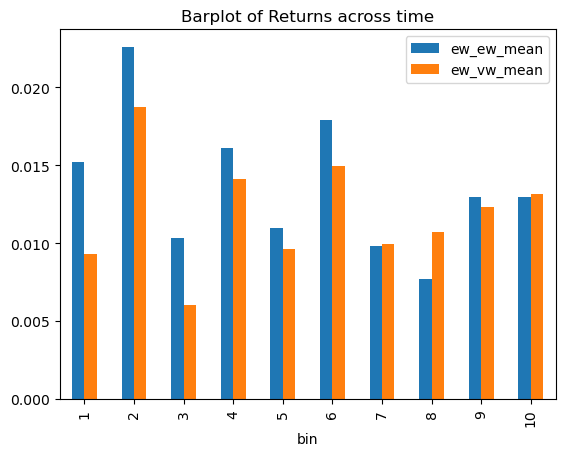

In [26]:
(
    portfolios
    .groupby('bin')
    .agg(ew_ew_mean=('ew_ret', 'mean'), ew_vw_mean=('vw_ret', 'mean'))
    .plot(kind='bar')
    .set_title('Barplot of Returns across time')
)

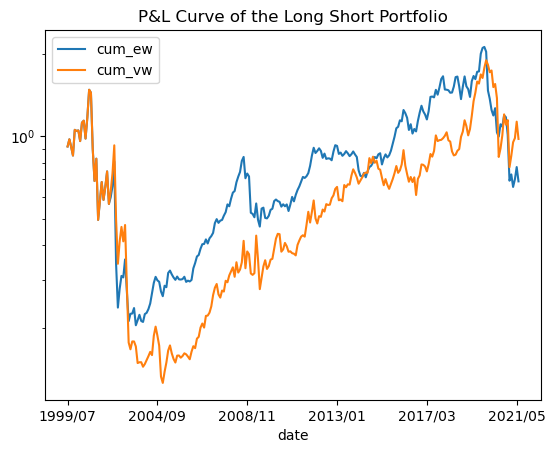

In [21]:
portfolio_LS.set_index('date')[['cum_ew', 'cum_vw']].plot(logy=True).set_title('P&L Curve of the Long Short Portfolio');